In [1]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

In [3]:
df['Region'].value_counts()

Region
VIC    1251
QLD     376
SA      286
NSW     272
TAS     145
Name: count, dtype: int64

In [4]:
# create categories for duration 
bins = [0, 6, 12, 24, 24*7, float('inf')] 
labels = ['0-6 hr', '6-12 hr', '12-24 hr', '24hr-1wk', '1+wk']
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, right=False)

In [5]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# # ---  Select Features and Target
# features = ['Region', 'NSP', 'Recall_Day_Hours', 'Recall_Night_Hours',
#             'Project Work?', 'DNSP Aware?', 'Generator Aware?',
#             'Inter-Regional', 'Asset Type', 'Reason']

# X = df[features]
# y = df['Duration_Category']

# # --- Encode Categorical Variables
# X = X.copy()
# for col in ['Region', 'NSP', 'Asset Type', 'Reason']:
#     X[col] = LabelEncoder().fit_transform(X[col])

# # --- Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # --- Random Forest Classifier
# clf = RandomForestClassifier(random_state=42)
# clf.fit(X_train, y_train)

# # --- Feature Importance
# importances = clf.feature_importances_
# feature_names = X.columns


In [6]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import (
#     classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# )
# import matplotlib.pyplot as plt

# def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42):

#     # --- 1. Select Features and Target
#     features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
#                 'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
#                 'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical coumns
#                 ] 
#     target = 'Duration_Category'

#     X = df[features].copy()
#     y = df[target]

#     # --- 2. Encode Categorical Features
#     for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
#         X[col] = LabelEncoder().fit_transform(X[col])

#     # --- 3. Train/Test Split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state
#     )

#     # --- 4. Train Model (if needed)
#     if train_model or model is None:
#         model = RandomForestClassifier(random_state=random_state)
#         model.fit(X_train, y_train)

#     # --- 5. Predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # --- 6. Accuracy
#     train_acc = accuracy_score(y_train, y_train_pred)
#     test_acc = accuracy_score(y_test, y_test_pred)

#     # --- 7. Get present labels (classes that actually exist)
#     full_label_order = ['0-6 hr', '6-12 hr', '12-24 hr', '24hr-1wk', '1w-1mo', '1+mo']
#     present_labels = [label for label in full_label_order if label in y_test.unique()]


#     # --- 8. Classification Report
#     print("Classification Report (Test Set):")
#     print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

#     # --- 9. Visualization
#     fig, axes = plt.subplots(1, 3, figsize=(24, 6))

#     # Feature Importances
#     importances = model.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     feature_names = X.columns

#     axes[0].barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
#     axes[0].invert_yaxis()
#     axes[0].set_title("Feature Importances")
#     axes[0].set_xlabel("Importance")

#     # Confusion Matrices
#     cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
#     cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

#     disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
#     disp_train.plot(ax=axes[1], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     axes[1].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

#     disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
#     disp_test.plot(ax=axes[2], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     axes[2].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

#     plt.tight_layout()
#     plt.show()

#     return model  # Return model for possible reuse

Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.65      0.57      0.61        30
     6-12 hr       0.74      0.85      0.79       202
    12-24 hr       0.79      0.65      0.71       115
    24hr-1wk       0.82      0.79      0.80        94

   micro avg       0.76      0.77      0.76       441
   macro avg       0.75      0.71      0.73       441
weighted avg       0.76      0.77      0.76       441



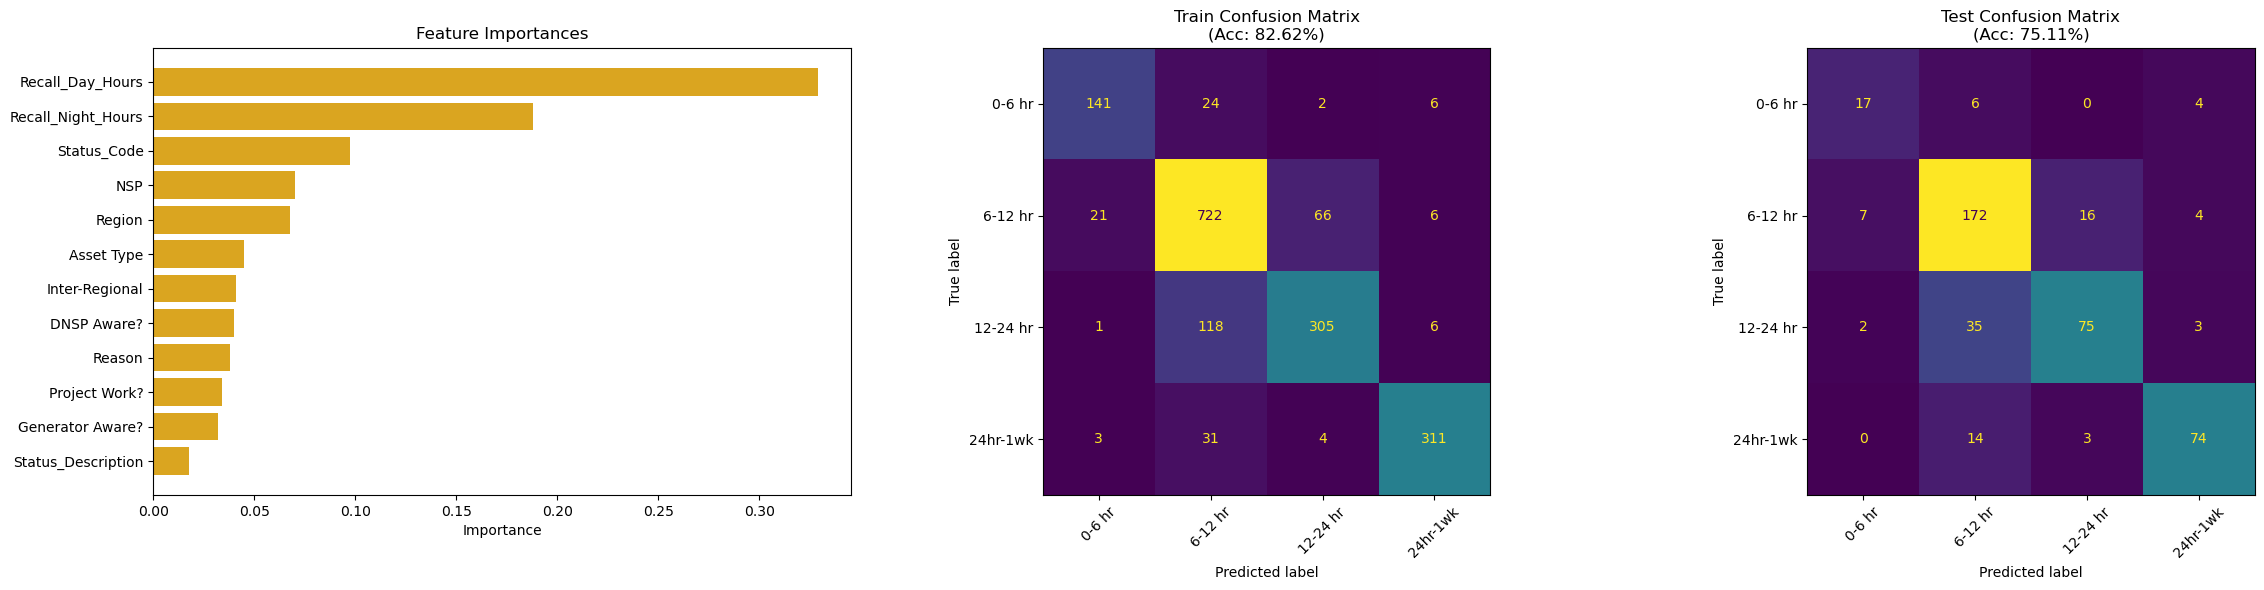

In [7]:
from data.functions.random_forest_model_and_eval import train_and_evaluate_rf
model = train_and_evaluate_rf(df)

--- Region: SA ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.50      0.33      0.40        12
     6-12 hr       0.67      0.40      0.50         5
    12-24 hr       0.29      0.67      0.40         3
    24hr-1wk       0.82      0.89      0.85        35

   micro avg       0.70      0.71      0.70        55
   macro avg       0.57      0.57      0.54        55
weighted avg       0.70      0.71      0.70        55



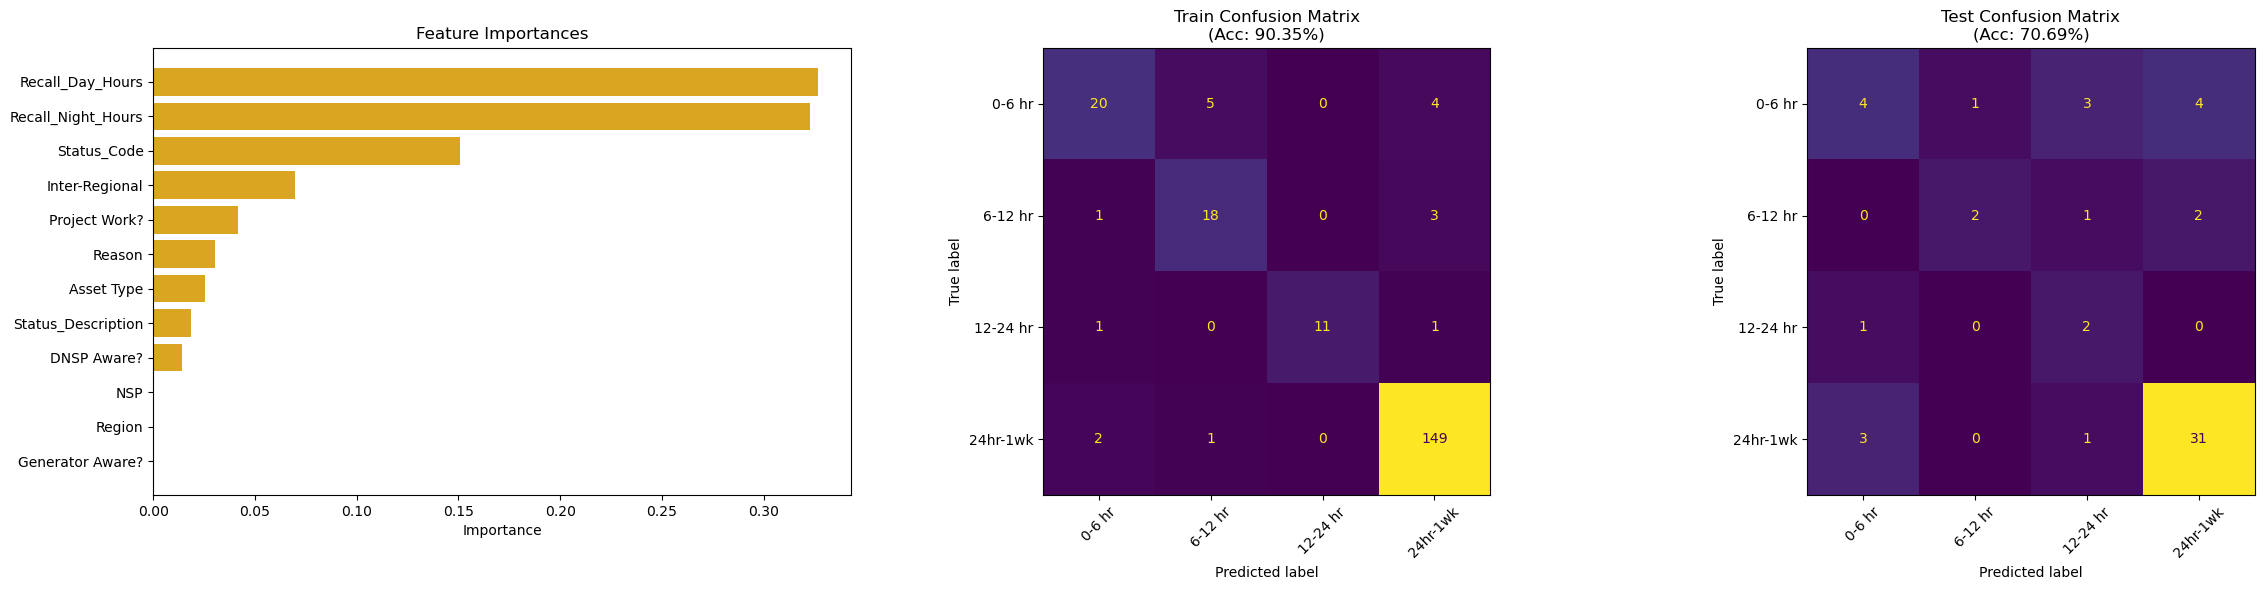

--- Region: VIC ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.75      0.60      0.67        10
     6-12 hr       0.70      0.83      0.76       122
    12-24 hr       0.78      0.69      0.73       101
    24hr-1wk       0.86      0.38      0.52        16

   micro avg       0.73      0.73      0.73       249
   macro avg       0.77      0.62      0.67       249
weighted avg       0.74      0.73      0.73       249



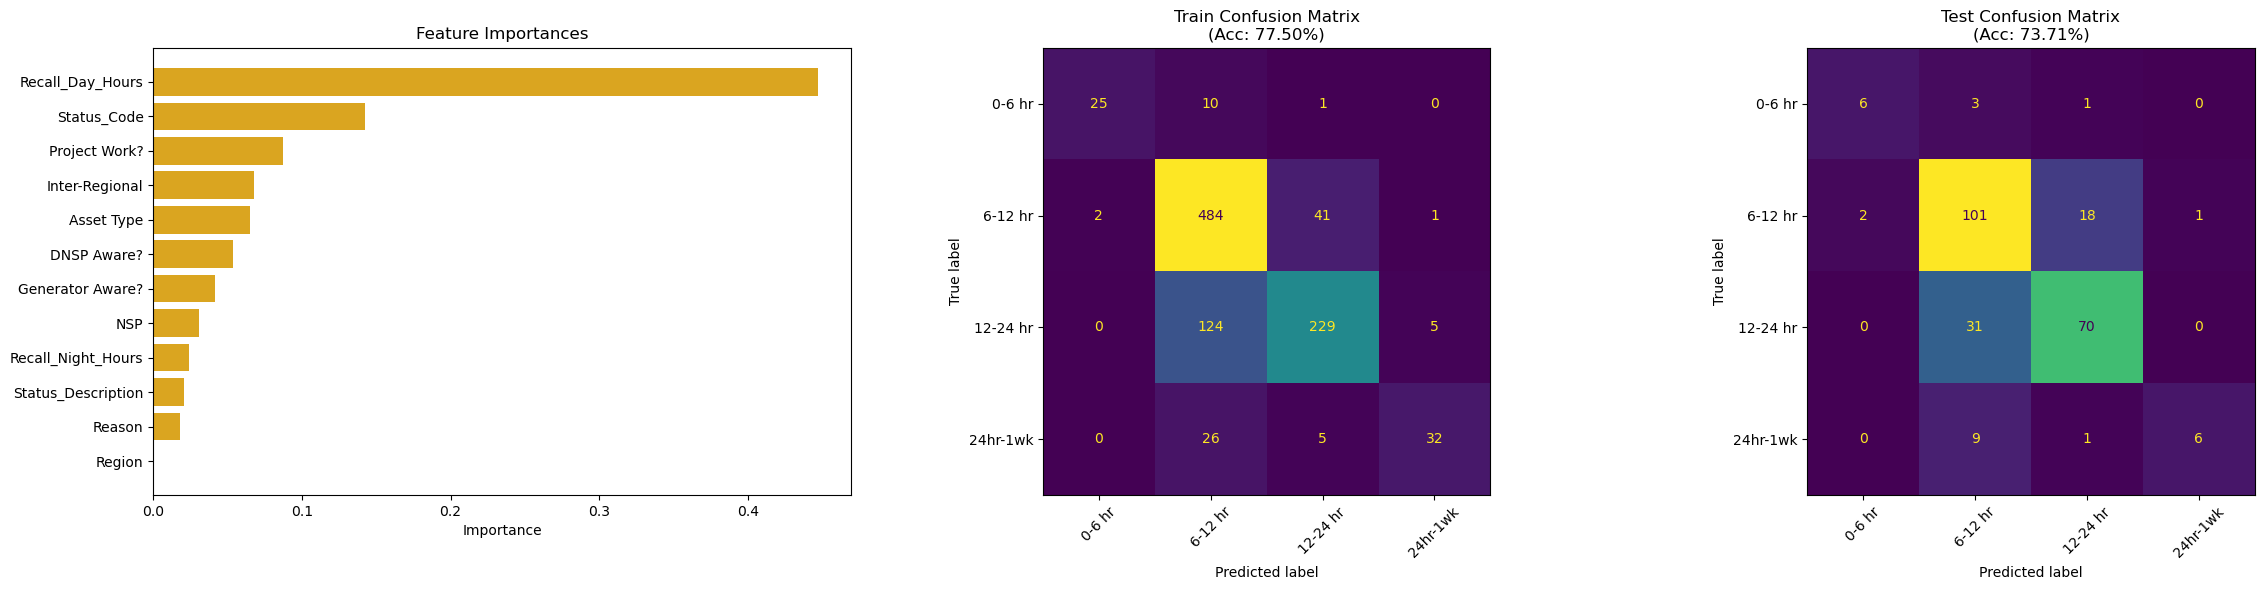

--- Region: TAS ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.78      0.78      0.78         9
     6-12 hr       0.62      0.89      0.73         9
    24hr-1wk       1.00      0.78      0.88         9

   micro avg       0.76      0.81      0.79        27
   macro avg       0.80      0.81      0.79        27
weighted avg       0.80      0.81      0.79        27



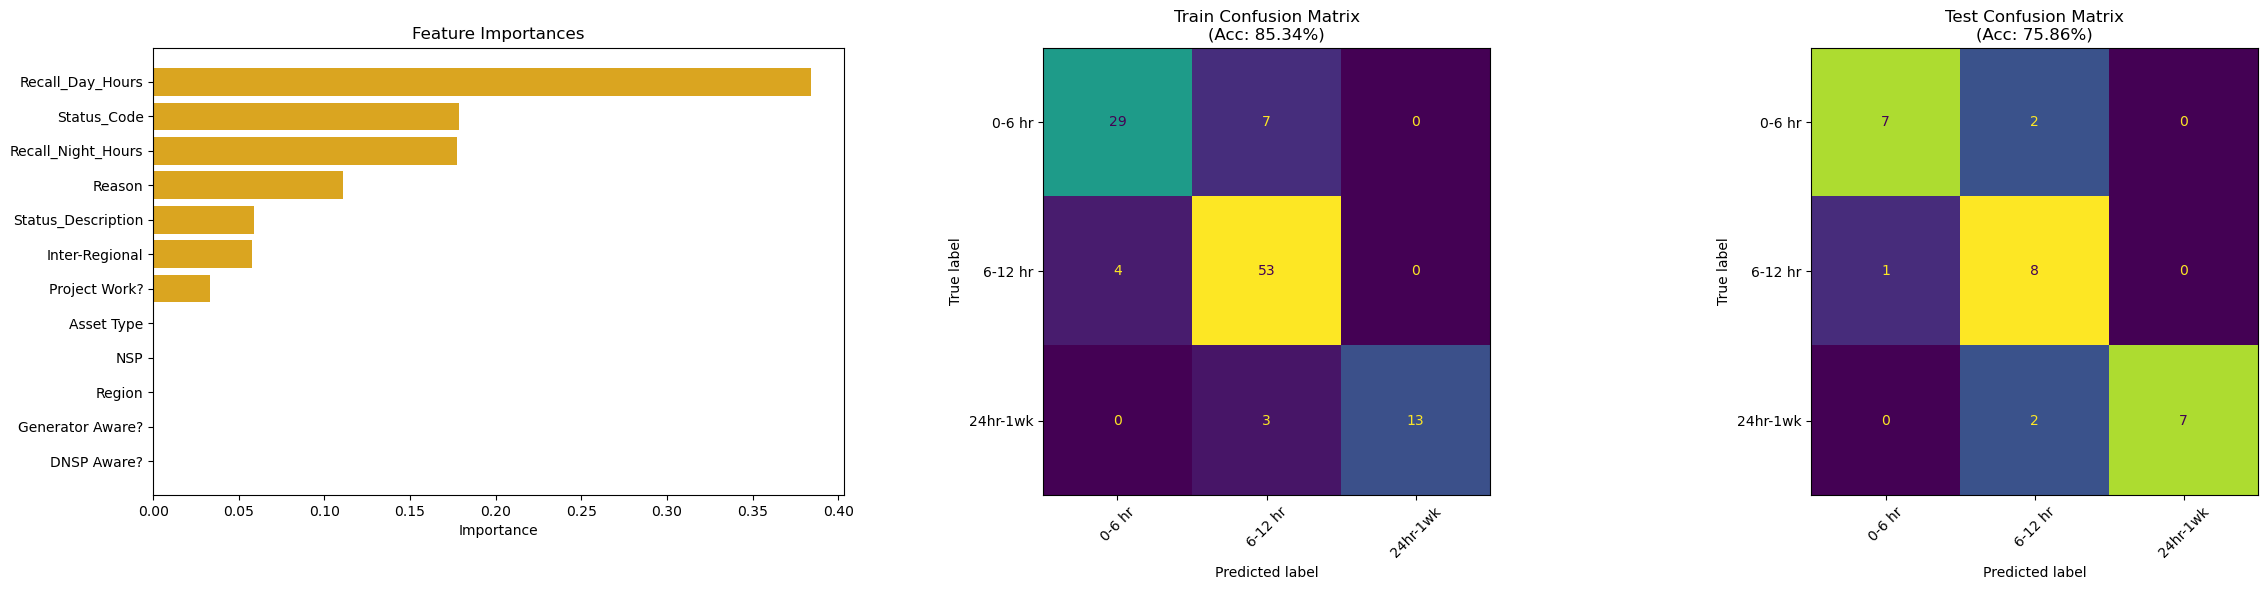

--- Region: QLD ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.67      0.60      0.63        10
     6-12 hr       0.87      0.79      0.83        34
    24hr-1wk       0.82      0.90      0.86        20

   micro avg       0.82      0.80      0.81        64
   macro avg       0.79      0.76      0.77        64
weighted avg       0.82      0.80      0.81        64



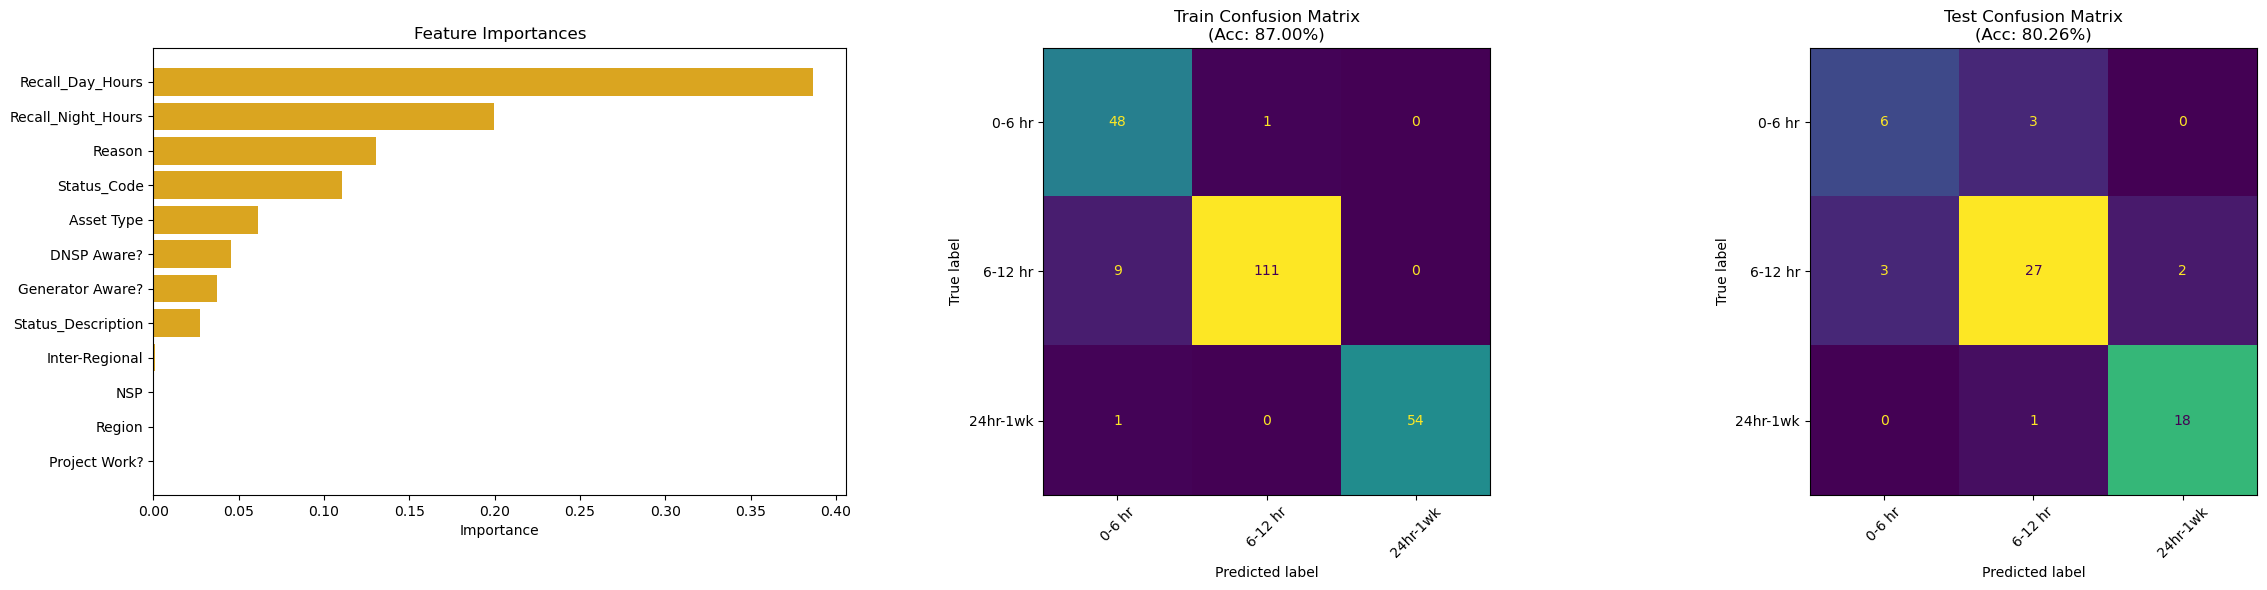

--- Region: NSW ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.67      0.67      0.67         3
     6-12 hr       0.80      0.80      0.80        20
    12-24 hr       0.40      0.44      0.42         9
    24hr-1wk       0.82      0.82      0.82        22

   micro avg       0.73      0.74      0.73        54
   macro avg       0.67      0.68      0.68        54
weighted avg       0.73      0.74      0.74        54



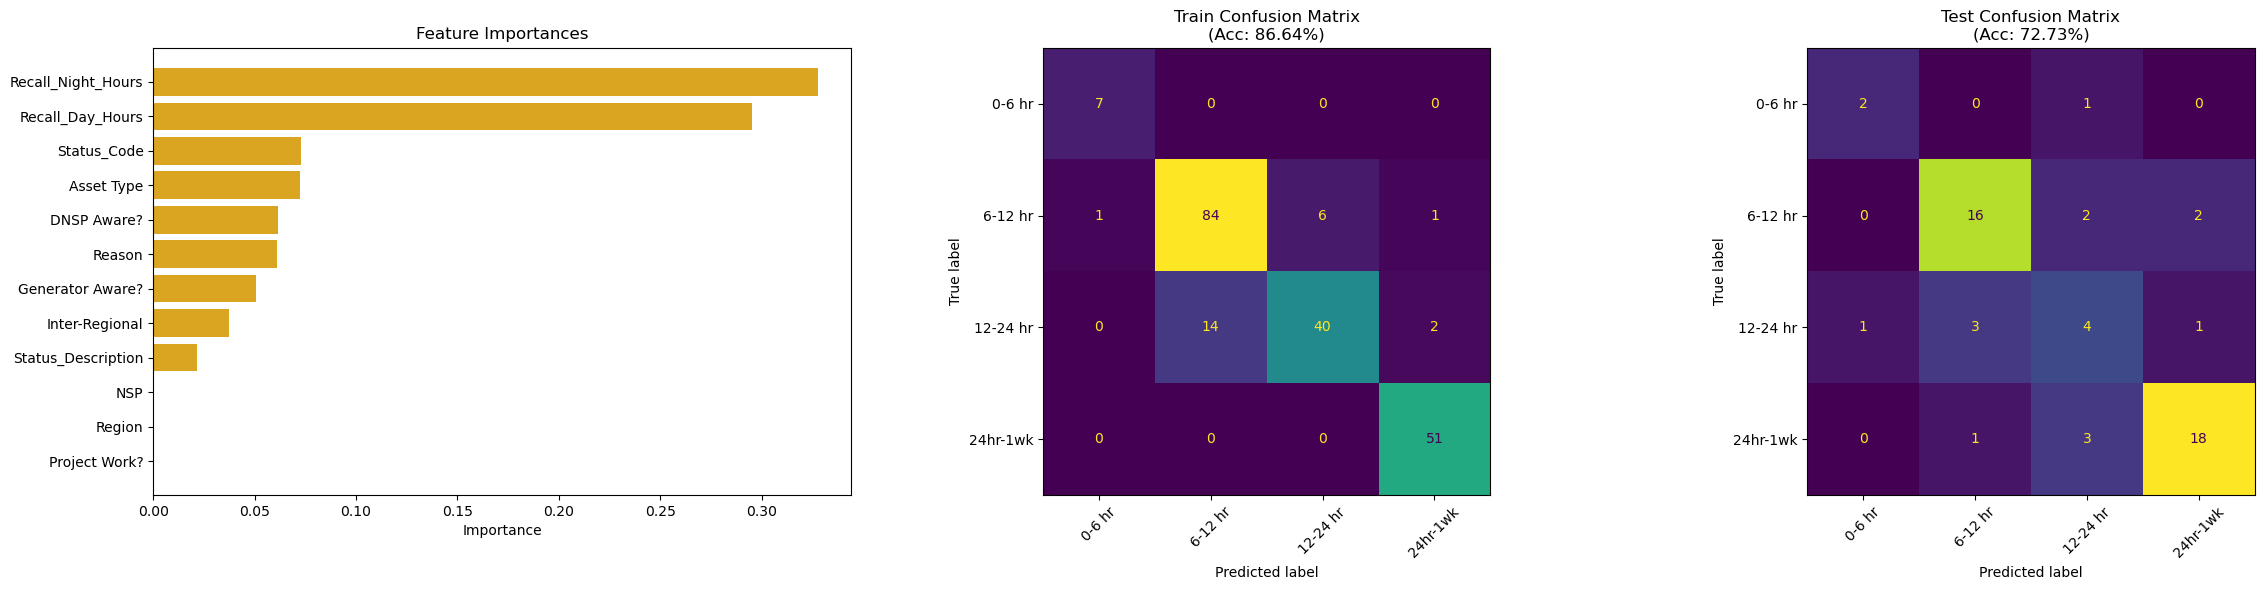

In [8]:
region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_rf(region_df)
    region_models[region] = model
